# Part III: Post analysis (Python/Jupyter/Colab)

This tutorial is a Jupyter notebook that illustrates how to load & open output files from Tapqir analysis. **To work with the live version of the notebook run it in Google Colab using the link above**.

## Set up the environment

* Change runtime to GPU (in the menu select `Runtime -> Change runtime type -> GPU`)
* Connect Google Drive to be able to save the analysis output (to view Files & Folders click on a Folder icon on the left):

In [1]:
# Run this cell to connect to Google Drive
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


* Run the cell below to install `tapqir` (takes about a minute):

In [2]:
!pip install --quiet git+https://github.com/gelles-brandeis/tapqir.git > install.log

## Load data & analysis results

Extracted AOI images are stored in a `data.tpqr` file; analysis results are stored in a `cosmos-channel0-params.tpqr` and `cosmos-channel0-summary.csv` files. We will import `cosmos` model from `tapqir`, create its instance, and then call `.load`method to load these files:

In [3]:
# import cosmos model
from tapqir.models import Cosmos

# create a cosmos model instance
model = Cosmos()
# load analysis results from the working directory
model.load(path="/content/drive/MyDrive/tutorial", data_only=False)

[KeOps] Warning : cuda was detected, but driver API could not be initialized. Switching to cpu only.


### AOI images

In [4]:
# data can be accessed through .data attribute
model.data

CosmosDataset: Rpb1SNAP549
  images           tensor(N=331 on-target AOIs, Nc=526 off-target AOIs, F=790 frames, C=1 channels, P=14 pixels, P=14 pixels)
  x                tensor(N=331 on-target AOIs, Nc=526 off-target AOIs, F=790 frames, C=1 channels)
  y                tensor(N=331 on-target AOIs, Nc=526 off-target AOIs, F=790 frames, C=1 channels)

  offset.samples   tensor([ 90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
                          104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116],
                         dtype=torch.int32)
        .weights   tensor([2.8129e-06, 6.7511e-05, 4.1210e-04, 1.7932e-03, 7.1871e-03, 2.1366e-02,
                          4.7677e-02, 9.0093e-02, 1.3192e-01, 1.6421e-01, 1.5248e-01, 1.0433e-01,
                          7.7949e-02, 5.2655e-02, 3.5667e-02, 2.2335e-02, 1.9520e-02, 1.6328e-02,
                          1.2553e-02, 8.6892e-03, 7.2546e-03, 5.8228e-03, 4.4402e-03, 3.1153e-03,
                    

Data is stored as a `CosmosDataset` object that has a title (`Rpb1SNAP549`), `images` attribute for AOI images (torch.Tensor object with `(N+Nc, F, C, P, P)` shape), `x` attribute for target locations on the _x_-axis (torch.Tensor with `(N+Nc, F, C)` shape), and `y` attribute for target locations on the _y_-axis (torch.Tensor with `(N+Nc, F, C)` shape), and `offset` attribute for camera offset data.

As an example let's plot frames 625, 628, 630, 633, 635, 638, 640, 643, 645 from AOI 163 and also show target locations (red `+` sign).

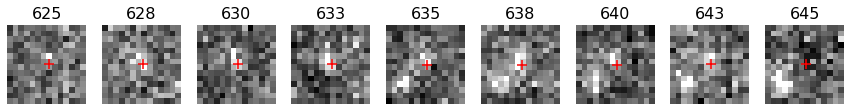

In [5]:
# import matplotlib for plotting
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15, 1.5))
n = 163  # AOI
c = 0  # color channel
frames = [625, 628, 630, 633, 635, 638, 640, 643, 645]

for i, f in enumerate(frames):
    ax = fig.add_subplot(1, 9, i + 1)
    ax.imshow(model.data.images[n, f, c].numpy(), vmin=340, vmax=635, cmap="gray")
    ax.scatter(
        model.data.x[n, f, c].item(),
        model.data.y[n, f, c].item(),
        c="r",
        s=100,
        marker="+",
    )
    ax.set_title(f, fontsize=16)
    ax.axis("off")

### Offset distribution

`offset` is an `OffsetData` object that has `samples` attribute for camera offset values and `weights` attribute for their probabilities (together they define and Empirical distribution for the offset signal). Let's plot it.

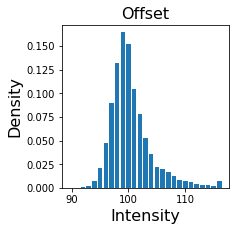

In [6]:
plt.figure(figsize=(3, 3))
plt.bar(model.data.offset.samples, model.data.offset.weights)
plt.title("Offset", fontsize=16)
plt.ylabel("Density", fontsize=16)
plt.xlabel("Intensity", fontsize=16)
plt.show()

## Parameters

Model parameters with 95% CI (credible interval) are stored in `cosmos-params.tpqr` file (nested dictionary of `torch.Tensor`s). It can be accessed using a `.params` attribute:

In [7]:
# list all parameters
model.params.keys()

dict_keys(['gain', 'proximity', 'lamda', 'pi', 'Keq', 'height', 'width', 'x', 'y', 'background', 'm_probs', 'theta_probs', 'z_probs', 'z_map', 'p_specific', 'time1', 'ttb', 'h_specific', 'chi2'])

- `gain` - $g$ camera gain
- `proximity` - $\sigma^{xy}$ proximity
- `lamda` - $\lambda$ off-target binding rate
- `pi` - $\pi$ average on-target binding probability
- `Keq` - equilibrium constant calculated as $\frac{\pi}{1-\pi}$
- `z_probs` - $p(z=1|D)$ probability of there being any target-specific spot in an AOI image
- `p_specific` - $p(\mathsf{specific})$ probability of there being any target-specific spot in an AOI image
- `z_map` - most likely value (0 or 1) for target-specific spot presence (obtained from $p(\mathsf{specific})$ using 0.5 cutoff)
- `theta_probs` - $p(\theta=k|D)$ target-specific spot index probabilities
- `m_probs` - $p(m=1|D)$ spot presence probabilities
- `height` - $h$ spot intensity
- `width` - $w$ spot width
- `x` - $x$ spot position on _x_-axis
- `y` - $y$ spot position on _y_-axis
- `background` - $b$ background intensity


For example, let's look at gain $g$:

In [9]:
model.params["gain"]

{'LL': tensor(6.7340), 'Mean': tensor(6.7366), 'UL': tensor(6.7391)}

It is a dictionary with the values of the mean (`Mean`), 95% credible interval lower-limit (`LL`) and upper-limit (`UL`).

Let's plot $p(\mathsf{specific})$ for AOI 163 and frames from 625 to 645:

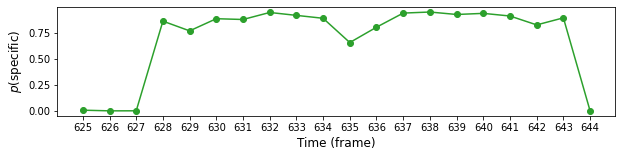

In [10]:
n = 163
f1, f2 = 625, 645

plt.figure(figsize=(10, 2))
plt.plot(range(f1, f2), model.params["z_probs"][n, f1:f2], "o-", color="C2")
plt.ylabel(r"$p(\mathsf{specific})$", fontsize=12)
plt.xlabel("Time (frame)", fontsize=12)
plt.xticks(range(f1, f2))
plt.show()

To plot credible intervals we can use `pyplot`'s `fill_between` method. Here is the plot of intensity $h$ for spot 1 in the same range of frames:

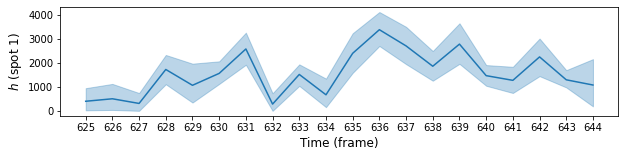

In [11]:
k = 0  # spot 1
n = 163  # AOI
f1, f2 = 625, 645  # frame range

plt.figure(figsize=(10, 2))
plt.plot(range(f1, f2), model.params["height"]["Mean"][k, n, f1:f2], "-", color="C0")
plt.fill_between(
    range(f1, f2),
    model.params["height"]["LL"][k, n, f1:f2],
    model.params["height"]["UL"][k, n, f1:f2],
    color="C0",
    alpha=0.3,
)
plt.ylabel(r"$h$ (spot 1)", fontsize=12)
plt.xlabel("Time (frame)", fontsize=12)
plt.xticks(range(f1, f2))
plt.show()

Here we plot ntensities of target-specifics.  Target-specific spot is selected from two spots using 0.5 probability cut-off.

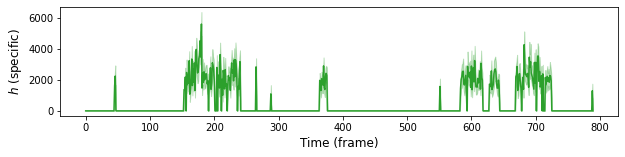

In [12]:
n = 163  # AOI
theta_mask = model.params["theta_probs"][:, n] > 0.5
height_mean = (model.params["height"]["Mean"][:, n] * theta_mask).sum(0)
height_ll = (model.params["height"]["LL"][:, n] * theta_mask).sum(0)
height_ul = (model.params["height"]["UL"][:, n] * theta_mask).sum(0)

plt.figure(figsize=(10, 2))
plt.plot(range(0, model.data.F), height_mean, "-", color="C2")
plt.fill_between(
    range(0, model.data.F),
    height_ll,
    height_ul,
    color="C2",
    alpha=0.3,
)
plt.ylabel(r"$h$ (specific)", fontsize=12)
plt.xlabel("Time (frame)", fontsize=12)
plt.show()

### Probabilistic rastergram

We can plot $p(\mathsf{specific})$ as a probabilistic rastergram.

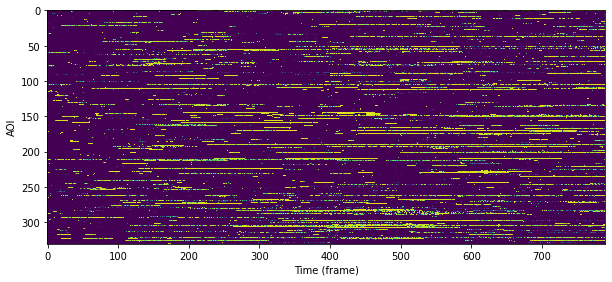

In [13]:
import matplotlib as mpl

plt.figure(figsize=(10, 5))
plt.imshow(
    model.params["z_probs"][: model.data.N],
    norm=mpl.colors.Normalize(vmin=0, vmax=1),
    aspect="equal",
    interpolation="none",
)
plt.ylabel("AOI")
plt.xlabel("Time (frame)")
plt.show()

### Global parameters

`summary` attribute (loaded from the `cosmos-channel0-summary.csv` file) contains values of global parameters (for easy access). 

In [14]:
model.summary

,Mean,95% LL,95% UL
gain,6.736577,6.733957,6.739063
proximity,0.607815,0.604374,0.611293
lamda,0.288701,0.287088,0.290315
pi,0.092999,0.092030,0.094001
Keq,0.102535,0.101358,0.103754
SNR,1.607642,NaN,NaN


## Kinetic analysis

Here we replicate analysis done in Figure 6B and its supplements in [Ordabayev et al., 2021](https://doi.org/10.1101/2021.09.30.462536) where association rate constant is estimated form the time-to-first binding data.

In [15]:
import torch
import pyro
from pyro.ops.stats import hpdi
import pandas as pd
from pyro import distributions as dist
from tapqir.utils.imscroll import time_to_first_binding
from tapqir.utils.mle_analysis import train, ttfb_guide, ttfb_model

In [ ]:
# number of frames
Tmax = model.data.F
# the model assumes that there is no target-specific biding in control data
control = None
# set random seed number for reproducibility
torch.manual_seed(0)
# Monte-Carlo samples from p(specific)
z = dist.Bernoulli(model.params["z_probs"][: model.data.N]).sample((500,))
# calculate time-to-first binding for each AOI and Monte-Carlo sample
data = time_to_first_binding(z)

# set device to cuda
torch.set_default_tensor_type(torch.cuda.FloatTensor)

# fit to ttfb_model which is described in Friedman and Gelles, 2015
train(
    ttfb_model,
    ttfb_guide,
    lr=5e-3,
    n_steps=15000,
    data=data.cuda(),
    control=control,
    Tmax=Tmax,
    jit=False,
)
# set device back to cpu
torch.set_default_tensor_type(torch.FloatTensor)

Calculate mean and 95% CI for each parameter (ka, kns, Af)

In [ ]:
results = pd.DataFrame(columns=["Mean", "95% LL", "95% UL"])

results.loc["ka", "Mean"] = pyro.param("ka").mean().item()
ll, ul = hpdi(pyro.param("ka").data.squeeze(), 0.95, dim=0)
results.loc["ka", "95% LL"], results.loc["ka", "95% UL"] = ll.item(), ul.item()

results.loc["kns", "Mean"] = pyro.param("kns").mean().item()
ll, ul = hpdi(pyro.param("kns").data.squeeze(), 0.95, dim=0)
results.loc["kns", "95% LL"], results.loc["kns", "95% UL"] = ll.item(), ul.item()

results.loc["Af", "Mean"] = pyro.param("Af").mean().item()
ll, ul = hpdi(pyro.param("Af").data.squeeze(), 0.95, dim=0)
results.loc["Af", "95% LL"], results.loc["Af", "95% UL"] = ll.item(), ul.item()

results

,Mean,95% LL,95% UL
ka,0.00982663,0.00723476,0.0128643
kns,0.00314122,0.00195201,0.0045297
Af,0.644478,0.441986,0.857144


Probabilistic rastergram with AOIs ordered by time-to-first binding:

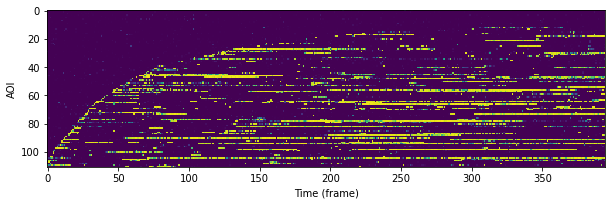

In [ ]:
# sorted on-target
ttfb = time_to_first_binding(model.params["z_map"][: model.data.N])
# sort ttfb
sdx = torch.argsort(ttfb, descending=True)

plt.figure(figsize=(10, 5))
norm = mpl.colors.Normalize(vmin=0, vmax=1)
im = plt.imshow(
    model.params["z_probs"][: model.data.N][sdx][::3, ::2],
    norm=norm,
    aspect="equal",
    interpolation="none",
)
plt.xlabel("Time (frame)")
plt.ylabel("AOI")
cbar = plt.colorbar(im, ax=ax, aspect=8, shrink=0.9)
cbar.set_label(label=r"$p(\mathsf{specific})$")

Fraction bound and the best-fit curve plot.

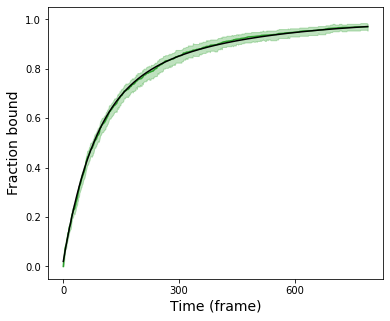

In [ ]:
nz = (data == 0).sum(1, keepdim=True)
n = (data == Tmax).sum(1, keepdim=True)
N = data.shape[1]

fraction_bound = (data.unsqueeze(-1) < torch.arange(Tmax)).float().mean(1)
fb_ll, fb_ul = hpdi(fraction_bound, 0.95, dim=0)

x = torch.arange(Tmax)

plt.figure(figsize=(6, 5))
plt.fill_between(torch.arange(Tmax), fb_ll, fb_ul, alpha=0.3, color="C2")
plt.plot(torch.arange(Tmax), fraction_bound.mean(0), color="C2")

plt.plot(
    torch.arange(Tmax),
    (
        nz / N
        + (1 - nz / N)
        * (
            results.loc["Af", "Mean"]
            * (
                1
                - torch.exp(
                    -(results.loc["ka", "Mean"] + results.loc["kns", "Mean"])
                    * torch.arange(Tmax)
                )
            )
            + (1 - results.loc["Af", "Mean"])
            * (1 - torch.exp(-results.loc["kns", "Mean"] * torch.arange(Tmax)))
        )
    ).mean(0),
    color="k",
)
plt.xticks([0, 300, 600])
plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
plt.xlabel("Time (frame)", fontsize=14)
plt.ylabel("Fraction bound", fontsize=14)
plt.ylim(-0.05, 1.05)
plt.show()